In [50]:
import pandas as pd
import numpy as np

## Data Structure

Every weekend, a new round of the Numerai tournament begins. This includes the release of 2 datasets: ```numerai_training_data.csv``` and ```numerai_tournament_data.csv```. <br>
There are three ways of getting this data: 1) Downloading it locally from numer.ai/submit (under Advanced) 2) Querying it from the server 3) From the official Python client to Numerai's API ```numerapi``` [Installation/Documentation](https://github.com/uuazed/numerapi)

In [4]:
## Method 1: Locally saved csv files
TRAINING_DATAPATH = 'Data/numerai_training_data.csv'
TOURNAMENT_DATAPATH = 'Data/numerai_tournament_data.csv'

df_train = pd.read_csv(TRAINING_DATAPATH)
df_tournament = pd.read_csv(TOURNAMENT_DATAPATH)

## Method 2: Querying from server
TRAINING_DATAPATH = 'https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz'
TOURNAMENT_DATAPATH = 'https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz'

df_train = pd.read_csv(TRAINING_DATAPATH)
df_tournament = pd.read_csv(TOURNAMENT_DATAPATH)

## Method 3: Numerai API
## This will download and create a subfolder with the relevant files. Then, follow Method I.
import numerapi
napi = numerapi.NumerAPI(verbosity='info')
napi.download_current_dataset(unzip=True)

### Training Data

There are 501,808 samples to train your model with. The ```id``` column is an obfuscated key that is **unique** in the entire dataset, and ```era``` is a time period corresponding to a trading day. <br>
Feature columns are named ```feature_{group}{number}``` and are categorized into 6 groups: intelligence, charisma, strength, dexterity, constitution, and wisdom. <br>
Target column is named ```target_{tournament name}``` and is the target that you are trying to predict. <br>

In [81]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 314 entries, id to target
dtypes: float64(311), object(3)
memory usage: 1.2+ GB


,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.75
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.00
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.00
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


We can use regular expressions to get a count of how many features are in each group *(Optional)*

In [73]:
from collections import Counter
import re

# Feature columns
features = df_train.columns[df_train.columns.str.startswith('feature')]

groupCount = Counter()
for feature in features:
    _, group_n = feature.split('_')
    group, n = re.split(r'\d+', group_n)
    groupCount[group] += 1
groupCount

Counter({'intelligence': 12,
         'charisma': 86,
         'strength': 38,
         'dexterity': 14,
         'constitution': 114,
         'wisdom': 46})

There are 120 eras, with an average of 4182 observations per era. The minimum observations by era is 2371 and the maximum is 4893. Notice that the earlier eras generally have less observations. <br>
*Do autoregressive models make sense? Can we figure out persistent patterns in feature groups or eras?*

,Observations
count,120.000000
mean,4181.733333
std,583.884482
min,2371.000000
25%,3929.250000
50%,4388.500000
75%,4582.750000
max,4893.000000


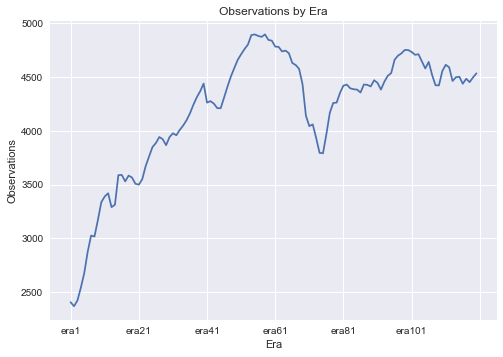

In [172]:
# Number of observations by era
eraCount = Counter()
for era in df_train['era']:
    eraCount[era] += 1
eraCount = pd.DataFrame.from_dict(eraCount, orient='index', columns=['Observations'])
eraCount.plot(legend=None)
plt.xlabel('Era')
plt.ylabel('Observations')
plt.title('Observations by Era')
eraCount.describe()

Features are all pre-processed and have similar scaling between $[0,1]$. The dataset is very clean - there are no missing values.

In [80]:
df_train[features].describe()

,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,...,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46
count,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,...,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000
mean,0.499981,0.499979,0.499979,0.499981,0.499977,0.499977,0.499977,0.499981,0.499980,0.499980,...,0.499979,0.499982,0.499982,0.499974,0.499980,0.499982,0.499980,0.499974,0.499979,0.499971
std,0.353596,0.353593,0.353593,0.353596,0.353587,0.353587,0.353587,0.353596,0.352099,0.352099,...,0.352772,0.353139,0.353139,0.351328,0.350662,0.352151,0.352965,0.351328,0.347689,0.353419
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,...,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000
50%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
75%,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,...,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Targets are similarly scaled between $[0,1]$. Notice that both the features and targets are **discrete** and take on values in the set $\{0, 0.25, 0.50, 0.75, 1.0\}$. <br>
*Hint: Target classes are balanced. That is, the number of observations for each target value is approximately the same. How would this affect Classification and Regression models? What about rank correlation scores?*

In [195]:
# Target column
target = df_train.columns[df_train.columns.str.startswith('target')]

df_train[target].describe()

,target
count,501808.000000
mean,0.500002
std,0.352994
min,0.000000
25%,0.250000
50%,0.500000
75%,0.750000
max,1.000000


In [112]:
# Number of observations per target value
df_train[target].apply(lambda x: x.value_counts())

,target
0.50,101632
1.00,100047
0.25,100046
0.00,100042
0.75,100041


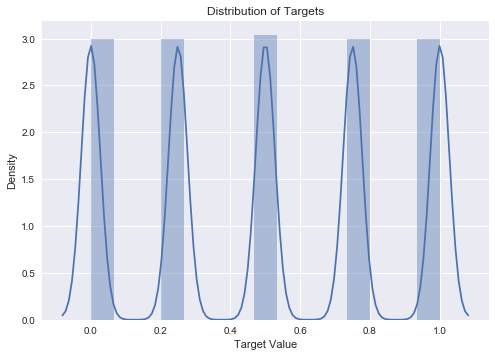

In [134]:
# Distribution of target values
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

sns.distplot(df_train[target], hist=True, kde=True, bins=15)
plt.xlabel('Target Value')
plt.ylabel('Density')
plt.title('Distribution of Targets')
plt.show()

*Tip: Since features and targets are discrete, we can convert the DataFrame to 16-bit floats to reduce memory usage/computational expense without losing precision.*

In [203]:
df_train[features] = df_train[features].astype(np.float16)
df_train[target] = df_train[target].astype(np.float16)

In [114]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 314 entries, id to target
dtypes: float16(311), object(3)
memory usage: 309.2+ MB


### Tournament Data

The structure of ```numerai_tournament_data``` is almost identical but with the inclusion of an additional column: ```data_type```. There are 56,261 observations corresponding to <br>
```data_type == validation``` which you can use to validate your model on out-of-sample performance. Predictions should be made on everything in the dataframe. <br>
*Note:* ```test``` *should not be confused with the standard testing set terminology as it does not contain any target values.*

In [174]:
df_tournament.info()

# Counts of different data types
df_tournament['data_type'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676031 entries, 0 to 1676030
Columns: 314 entries, id to target
dtypes: float64(311), object(3)
memory usage: 3.9+ GB


test          1614599
validation      56261
live             5171
Name: data_type, dtype: int64

In [127]:
df_tournament.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,...,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.00
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,...,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.25
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,...,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,...,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.75
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,...,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,1.00


## Splitting ```numerai_training_data``` into Training Data and Testing Data 

In general, it is a good idea to split the dataset into a training set, a validation set, and a holdout set. In this example, ```numerai_training_data``` is split into a training set ```train``` <br>
which will be used to train the model parameters, a validation set ```test``` which will be used to validate the architecture of the model. The samples from ```numerai_tournament_data``` <br>
where ```data_type=='validation'``` are set aside for now as a holdout set.

In [204]:
from sklearn.model_selection import train_test_split

# Percent of dataset to split into test set
TEST_SIZE = 0.25

# Splits the numerai_training_data into a training and validation set
train, test = train_test_split(df_train, test_size=TEST_SIZE, shuffle=True, random_state=42)
train_X, train_Y, test_X, test_Y = train[features], train[target], test[features], test[target]

## Example: Classification Model

### Preprocessing: Nominal vs Ordinal

When training classifiers, it can be useful to perform a transformation on the target values. There are two main approaches here depending on whether target values are treated as *nominal* or *ordinal*. <br>
In the *nominal* case, each distinct value of ```target``` is treated as a separate class. In other words, for $k$ possible values of ```target```, we create $k$ binary columns where one of them is unity while the rest zero. <br>
The transformation is then defined by $y\in\{0,0.25,0.5,0.75,1.0\} \mapsto \tau_{k}(y)\in\{0,1\} \quad (k\in\{0,1,2,3,4\})$. <br>
In the *ordinal* case, the order of distinct values of ```target``` matters (i.e. $5 < 500$ makes sense). For $k$ possible values of ```target```, we create a single column where target ranges between $0$ and $k-1$. <br>
The transformation is then defined by $y\in\{0,0.25,0.5,0.75,1.0\} \mapsto \tau(y)\in\{0,1,2,3,4\}.$ <br>
*Hint: Are the target values nominal or ordinal?*

In [184]:
# Example of target array
target = np.array([0.25,0,0.25,0.5,0,1,0.75]).reshape(-1,1)
print('Target:')
print(target)

# Nominal transformation
from sklearn.preprocessing import OneHotEncoder
nominal_enc = OneHotEncoder()
nominal_transform = nominal_enc.fit_transform(target)
print('Nominal Transformation:')
print(nominal_transform)

# Ordinal transformation
from sklearn.preprocessing import LabelEncoder
ordinal_enc = LabelEncoder()
ordinal_transform = ordinal_enc.fit_transform(np.ravel(target)) # ravel() changes the shape from (n_samples, 1) to (n_samples,)
print('Ordinal Transformation:')
print(ordinal_transform)

Target:
[[0.25]
 [0.  ]
 [0.25]
 [0.5 ]
 [0.  ]
 [1.  ]
 [0.75]]
Nominal Transformation:
  (0, 1)	1.0
  (1, 0)	1.0
  (2, 1)	1.0
  (3, 2)	1.0
  (4, 0)	1.0
  (5, 4)	1.0
  (6, 3)	1.0
Ordinal Transformation:
[1 0 1 2 0 4 3]


### Model: Regularized Logistic Regression with Stochastic Gradient Descent

This example implements a regularized logistic regression with stochastic gradient descent to try to predict the target. <br>
With each run, the *gradient* (a vector of directional derivatives) is computed against the ```loss``` function (prediction error), <br>
and the model takes a small step in the size of ```learning_rate``` to try to find a local/global minima.

In [201]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# Train the model
sgd = SGDClassifier(loss='log',
                    learning_rate='optimal',
                    max_iter=5
                    )
sgd.fit(train_X, train_Y)

# Predictions
train_predict = sgd.predict(train_X)
train_predict_prob  = sgd.predict_proba(train_X)
test_predict = sgd.predict(test_X)
test_predict_prob = sgd.predict_proba(test_X)

# Evaluate the model
print('Model performance on training set:')
roc_auc  = roc_auc_score(train_Y, train_predict_prob, multi_class='ovr', average='weighted')
print(f'ROC AUC Score: {roc_auc:.2}')
acc = accuracy_score(train_Y, train_predict)
print(f'Accuracy Score: {acc:.2}')

print('Model performance on testing set:')
roc_auc  = roc_auc_score(test_Y, test_predict_prob, multi_class='ovr', average='weighted')
print(f'ROC AUC Score: {roc_auc:.2}')
acc = accuracy_score(test_Y, test_predict)
print(f'Accuracy Score: {acc:.2}')

C:\Development\Anaconda\envs\Hambot\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Model performance on training set:
ROC AUC Score: 0.58
Accuracy Score: 0.25
Model performance on testing set:
ROC AUC Score: 0.57
Accuracy Score: 0.24


## Example: Regression Model

### Model: Multi-variate Linear Regression with OLS

This example implements a multi-variate linear regression of the feature space using Ordinary Least Squares estimator to try to predict the target.

In [208]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train the model
reg = LinearRegression()
reg.fit(train_X, train_Y)

# Predictions
train_predict = reg.predict(train_X)
test_predict = reg.predict(test_X)

# Evaluate the model
print('Model performance on training set:')
score = reg.score(train_X, train_Y)
mse = mean_squared_error(train_Y, train_predict)
print(f'Training R^2: {score}')
print(f'Training MSE: {mse}')

print('Model performance on testing set:')
score = reg.score(test_X, test_Y)
mse = mean_squared_error(test_Y, test_predict)
print(f'Test R^2: {score}')
print(f'Test MSE: {mse}')

Model performance on training set:
Training R^2: 0.003426947537167435
Training MSE: 0.12414564192295074
Model performance on testing set:
Test R^2: 0.0011130420437310828
Test MSE: 0.12456277757883072


*Tip: This is a hard dataset to tackle. Can you think of better models to use? Combine classification and regression models? Improve the architecture? Feature Engineering?*

## Estimating Performance Score and Payouts

Standard model metrics such as accuracy and mean squared error can be useful to evaluate the model's predictiveness during development. <br>
This example shows how to estimate your performance score (rank-correlation) on Numerai.

In [246]:
def RankCorrelationScore(Y_True, Y_Pred):
    """
    Inputs: Y_True (array-like) True targets
            Y_Pred (DataFrame) Predicted targets (should have an era column)
    """
    # Rank-correlation by era
    ranked_pred = Y_Pred.groupby('era').apply(lambda x: x['Prediction'].rank(pct=True, method="first")).values
    return np.corrcoef(np.ravel(Y_True.values), ranked_pred)[0,1]

# Convert predictions to DataFrame and add era column
train_prediction_df = pd.DataFrame(train_predict, index=train.index, columns=['Prediction'])
train_prediction_df['era'] = train['era']
train_score = RankCorrelationScore(train_Y, train_prediction_df)
print(f'Rank-Correlation Score on Training Set: {train_score}')

test_prediction_df = pd.DataFrame(test_predict, index=test.index, columns=['Prediction'])
test_prediction_df['era'] = test['era']
test_score = RankCorrelationScore(test_Y, test_prediction_df)
print(f'Rank-Correlation Score on Test Set: {test_score}')

Rank-Correlation Score on Training Set: -0.0034337212175776823
Rank-Correlation Score on Test Set: 0.00045281096978224333


## Submitting Predictions

After you have developed a model, validated it against the hold-out set in ```numerai_tournament_data```, and are satisfied with the performance, you can then make predictions for the tournament. <br>
Predictions should be made on everything in ```numerai_tournament_data``` as a new column called ```prediction_{tournament name}``` and must have an ```id``` column that **exactly** matches the <br>
tournament dataset. After a new round is announced during the weekend, submissions should be in by ```Monday 14:30 UTC```. For this example, the Linear Regression model will be used to make predictions. <br>
Uploading predictions can be done manually on the Numerai website by saving as a .csv file, or through the ```numerapi``` client by supplying it with your public/private API keys. <br>
*Note: The ```id``` column should not be set as the index but as a separate column.*

In [248]:
# Tournament predictions
tournament_predictions = reg.predict(df_tournament[features].values)
tournament_predictions = pd.DataFrame(tournament_predictions, columns=['prediction_kazutsugi'])

# Add the 'id' column
tournament_predictions['id'] = df_tournament['id']

tournament_predictions.head()

# Save to .csv
#tournament_predictions.to_csv('Predictions.csv', index=False)

,prediction_kazutsugi,id
0,0.475282,n0003aa52cab36c2
1,0.503029,n000920ed083903f
2,0.562873,n0038e640522c4a6
3,0.490533,n004ac94a87dc54b
4,0.492951,n0052fe97ea0c05f


## Additional Topics

### Preprocessing: Dimension Reduction

It can be useful to reduce the dimension of the feature set to reduce computational costs and attain certain convergence properties. <br>
There are many different methods to explore, including regularization, feature engineering, etc. This example uses Principal Component Analysis <br>
to transform the (possibly correlated) feature space into a set of orthogonal principal components where components are ordered in terms of their explained variance. <br>
*Note: The ```PCA()``` object should be fit **only** on the training set then transformed on the test/hold-out sets to avoid bias.* <br>
*Hint: How much variance should we keep in the second implementation? How does the signal-to-noise ratio look? What effect does the distribution of the feature space have on this?* <br>

In [ ]:
from sklearn.decomposition import PCA

# This implementation uses Minka (2000) to estimate the dimension of the lower-dimensional subspace
pca = PCA(n_components='mle')

# Alternatively, we may specify a desired % of variance to keep
pca = PCA(0.95)

pca.fit(train_X)
pca_train = pca.transform(train_X)
pca_test = pca.transform(test_X)

### Cross-Validation

When training the model, it can be useful to also validate the model's performance using $k$-fold cross-validation. By splitting the data into $k$ equally sized folds, <br>
the model's performance is trained on the $1,\dots,k-1$ folds and tested on the $k$th fold during each run. In general, $k$ should be set no less than the amount of <br>
data that is neccessary for the estimator to converge while setting $k=N$ where $N$ is the sample size is *leave-one-out* cross-validation.

In [ ]:
from sklearn.model_selection import cross_validate

# Number of folds
k = 5

# Estimator
reg = LinearRegression()

cross_validate(reg, train_X, train_Y, cv=k)